# **Finding LOVE with Linear Programming - Matchmaking and Date Planning**
In this python notebook, we will explore the interesting notion of solving abstract concepts like 'love' using mathematics. In particular, we will be looking at how Matchmaking and Date Planning can be constructed as Linear Optimization Problems.

A successful demonstration of this project showcases the viability of Linear Programming application on the dating scene and matchmaking algorithms.

Disclaimer: The findings of the following demonstration should be treated as a "proof of concept (POC)" as heavily simplified models of matchmaking and date planning were used. The intention for this project is educational and should be consumed as such. Keen readers should still be able to adjust the models for real-world implementation but this should be done at the reader's discretion.

In [1]:
# relevant imports

import pandas as pd
import numpy as np
from rsome import ro
from rsome import grb_solver as grb

import math
import random
import itertools

## **PART 1: THE MATCHMAKING MODEL**

The Matching Problem: we have a group of N participants looking to find love. How can we best match each participant with an ideal partner while satisfying everyone's preferences as much as possible?

### **Part 1.1 - Determining the factors for finding compatibility between two individuals.**

The first step in matchmatching is to determine the important considerations that people have when trying to find love. After doing some research, we found the following factors to be used in our love finding model. We hand-picked a small subset of important considerations for our POC model to demonstrate the working principle of matching people using the chosen factors.

*Our variables*
* **gender**
* **age**
* **interest**
* **preference for similarity**
* **traits**
* **seriousness**
* **value ranking**
* **duration of meetup**
* **availability**
* **budget** (used in date planning model - part 2)
* **distance** (used in date planning model - part 2)

Here are some other attributes that should be considered in an actual implementation but will be excluded in our Proof Of Concept Model for simplicity:
*rationale: showing that the above chosen factors can be used to match people demonstrates that the following factors will similarly be easily implementable.
* language
* income
* education
* job
* height/other physical attributes
* preference for smoking/alcohol
* personality
* moral values
* religion
* etc.

### **Methodology**
Here is a detailed mention of how we plan to match individuals using each of the considered factors shown above.

##### **Gender** and **Gender Preference**
For gender, participants are free to choose ONE of the 3 gender options that represents them: ['Male', 'Female', 'Others']. This is represented as a binary array, that is, the option 'Male' is equivalent to [1,0,0] in our model.

Each participant are also required to declare their preferred gender(s) in their partner. This option allows participants to select more than 1 gender for their ideal partner.

When matching, the model is required to pair individuals in a manner that respects both of their gender preferences. This is a constraint in the model.

##### **Age** and **Maximum Age Gap**
For age, participants are required to declare their age as an integer whole number.

Each participant are then required to specify the maximum age gap between them and their ideal partner.

During matching, the model is only allowed to pair individuals who satisfy one another's age requirement. This is a constraint in the model.

##### **Availability** and **Duration of meetup**
For availability, participants fit their calendar schedules for the week (they could do so months or a year in advanced but we will only look at the current week for our matching problem). This data will be represented as a binary 2d matrix where each row correspond to each day of the week (Mon-Sun) and each column represent a specific 1-hour time slot. We consider 1-hour timeslots from 8 am to 10 pm each day as that is assumed to be when most of our attractions are open and the "normal" dating hours.

For e.g. for Monday, Joe's availability might be [1,0,0,0,0,0,0,0,0,0,0,0,0,1]. Which means he is only available for 8 am - 9 am and 9pm to 10 pm.

Each participant are required to state their minimum & maximum preferred dating duration.
For e.g. minimum 3 hours, maximum 6 hours.

During matching, the model will only consider pairs where both parties calendar align such that the minimum dating duration of both parties are satisfied. When planning for activities, the planning model will consider the lower of the two parties' maximum preferred dating duration to satisfy and maximise everyone's time.

##### **Interest** and **Preference for similarity**
For interest, participants are given an array of 8 types of activities genre - namely: Adventure, Wellness, Sightseeing, Animals & Nature, Art & Culture, Food & Culinary, Fitness, and Recreational activities.

*Disclaimer: This list of genres are NOT exhaustive but they will suffice for our POC model.*

Participants are required to rank each activity genre on a scale from 1 - 5. The intention is to create an Interest Vector array that encapsulates the "interests" of a particular individual. This particular interest array is also reused in PART 2 for date planning.

On top of having an array of interest ranked, each participant will also specify their similarity preference in their partners, this preference value falls on a scale from 0% (Completely different from me) to 100% (Exactly like me).

The idea of have a 'preference for similarity' is to respect the idea that some people seek out people like themselves while others look for those who are more different than them.

To match two people based on interest, the model will consider how closely their interests align. Additionally, it will also account for the similarity/dissimilarity preferences for both parties.

##### **Traits**
For traits, participants are required to select a certain number of traits (that they feel represents them) from a list of 30 or so traits. The traits are namely: *Ambitious, Authentic, Caring, Cheerful, Committed, Confident, Creative, Easy-going, Energetic, Funny, Generous, Honest, Humble, Independent, Intelligent, Kind, Loyal, Mature, Open-minded, Optimistic, Outgoing, Patient, Practical, Respectful, Responsible, Romantic, Social, Supportive, Thoughtful, Trustworthy.*

*Disclaimer: This list of traits are NOT exhaustive but they will suffice for our POC model.*

The traits will be captured in the form of a binary vector array where 1 represents possessing a trait while 0 represents otherwise. For e.g. [1,0,1] could mean: "loyal", not "patient", "caring".

Note that participants can only choose up to a certain number of traits so as to prevent them from being "perfect" individuals, they must prioritise choosing traits that they believe truly represent themselves.

Each participant are also then required to select the same number of traits for their ideal partner (out of the same trait list).

The model will attempt to match two people by how closely their traits satisfy their partner's preferred traits and vice-versa. The idea is to perform some kind of similarity measure on the traits vector array as mentioned above.

##### **Seriousness**

For "seriousness", we consider the participants' "intention" or "goal" for joining our matchmaking service.

We identified that different people may be at different stages of their lives - some are looking to date to meet new people while others are looking to settle down with a long-term partner.

Participants are required to rank their "seriousness" by using a value that falls on a scale where 0% (I am strictly looking for friendship, I am not interested in a relationship at the moment) to 100% (I would like to settle down with a long-term partner).

To match two people on account of "seriousness", we will compare how different their answers are to this metric. The model will attempt to match people who are closer in "seriousness" since their goals for meeting one another align better.


##### **Value ranking**

For "value ranking", we simply get the participants to provide weights to each of the following factors mentioned above:
(1) Interest + similarity
(2) Traits
(3) Seriousness

Participants are give 10 points, they must allocate the 10 points as "weights" across each of the 3 compatibility measure and use up all the points. Each point has a weight of 0.1 and the more weight a factor is given, the more influence it has over the final compatibility score.

For example: if John allocates 3 points to Interest, 6 points to Traits and 1 points to Seriousness. The resulting compatibility score between him and his ideal partner (for him) would look like:

0.3 * interest compatibility + 0.6 * traits compatibility + 0.1 * seriousness compatibility.

*Note that since interest, traits and serious compatibility are all metrics with continuous scale (0-1) -> the resulting value from applying the weights as described above would also be 0-1*

The idea is to give individuals the freedom to determine how much they value each particular factor in finding a partner.
 
##### **Compatibility Score computation**
Last and probably most importantly, we derive the compatibility score using all of the above mentioned metrics. This score represents how compatible two individuals are and it falls on a scale from 0% (not compatible) to 100% (perfectly compatible).

It is important to note that compatiblility is NOT bi-directional in our interpretation, that is, person j's compatibility to person i need not be the same as person i's compatibility to person j. We have chosen this interpretation because in real life, we cannot expect other people to like us just as much as we like them (sometimes its more, sometimes less).

Nevertheless, we still assume a conservative estimate to finalize a pair's TRUE compatibility by considering the **minimum** of the two's compatibility score.

That is, if Z_ij represents a pair's true compatibility score, then Z_ij = min(C_ij, C_ji).

### **Part 1.2 Populating the data**
To test the robustness of our model, we need to populate the data randomly. We can randomize the characteristics of our love-seeking participants. Some randomization follow appropriate probability distribution functions to reflect some degree of realism (but this will not perfectly represent the real-world as many assumptions were made).

For example, we populated (randomly) the data such that there will be more people who identify as *male* and *female* than *others* (assumption: a small minority of people identify as 'others').

We also made it so that *males* are more likely to prefer *females* (with a small probability of deviation) and vice-versa but *others* are more uniform in their preference and hence more liberal about their preferred partner's gender.

We also assumed that most people preferred partners that are more similar to them (backed up by research: https://www.insider.com/opposites-do-not-attract-in-relationships-2018-2#:~:text=The%20idea%20that%20%22opposites%20attract,and%20become%20bigger%20over%20time.)

*As such, we made it more probable for people to prefer a **similarity** score > 50% (when randomly populating preference for similarity).

For **availability**, we assumed that people were more free on weekends and are more free during LUNCH and AFTERWORK hours for weekdays. The distribution is populated as such.

***Note: Here, we are also populating data for the date-planning model in PART TWO, so let's get some of the assumptions out of the way***

For **budget**, we allowed participants to hold a value from 0 to 100 dollars but we conservatively assume that most people are only okay with spending 20 - 50 dollars on a single date, so those numbers are more common.

For **distance**, we conservatively take a uniform range from 0 to 20 KM. This is to simulate people's appetite on travel based on the mode of transport they have access to. For example, if someone has a car, he/she would be more willing to travel further than someone who doesn't. Regardless, we will still take the lesser of the two distance preference when planning a date for two people.

***Data points that are not mentioned will follow a uniform distribution where there is equal probability in landing at each possible data point. This is fair as in reality, people are vastly different in these fields (e.g. interests) and this assumption does not harm our study.***

In [2]:
# FUNCTIONS TO POPULATE DATA (RANDOMLY BUT REASONABLY)

def randomize(n, start, end, probs = []):
    '''
    this function was used to populate age evenly
    and age_gap disproportionately (smaller age gap usually preferred).

    this function finds selects a random number from a range and repeats the trials n times.
    user can also define the probability array to define the weight of each number within the range.
    '''
    if not probs:
        return [random.randint(start, end) for _ in range(n)]
    
    else:
        return random.choices(range(start, end+1), weights = probs, k = n)
    
def populate_gender_pref(gender, gender_pref):
    ''' this function randomly populates people's preference for their partner's gender.
    people who identify as male are more likely to prefer female and vice versa. '''
    preferences = list()
    for g in gender:
        if g == [1,0,0]:
            probs = [0.01, 0.94, 0.01, 0.01, 0.01, 0.01, 0.01]
        elif g == [0,1,0]:
            probs = [0.94, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
        else:
            probs = [0.1, 0.1, 0.4, 0.1, 0.1, 0.1, 0.1]
            
        preferences.append(random.choices(gender_pref, weights = probs, k=1)[0])
        
    return preferences

def populate_interest(n, num_interest):
    ''' randomly populate interest arrays with varying scores -> uniform odds for liking/disliking each interest genre '''
    return [[random.randint(1,5) for i in range(num_interest)] for j in range(n)]

def populate_by_percentage(n):
    ''' randomly populate an array of scores ranging from 0% to 100% -> uniform odds for select each discrete percentage point (i.e. 1%, 2%, etc.)
    this is used for seriousness factor and can be also used for similarity preference field'''
    return [random.randint(0,100)/100 for i in range(n)]

def populate_similarity(n):
    ''' randomly populate an array of scores ranging from 0% to 100% but more weight is placed towards the higher percentages
    The rationale is that people are more likely to prefer similar partners in real life '''
    # this function increases the likelihood that people prefer more similar partners
    leftover = 100
    index = -1
    
    similarity = [0 for _ in range(101)]
    
    while leftover > 0:
        percent = random.randint(1, 3)
        
        # amount to allocate is more than leftover
        if percent > leftover:
            percent = leftover
        
        leftover -= percent
        similarity[index] = percent
        index -= 1
    
    return [x/100 for x in random.choices(range(0,101), weights = similarity, k = n)]

def populate_traits(n, choose, num_traits):
    ''' randomly populate traits array for every user. each user must select 10 out of 30 traits
    each trait has an equal chance of being selected. '''
    choices = choose # choose x from total number of traits
    
    traits = list()
    
    for i in range(n):
        trait = [0 for _ in range(num_traits)]
        
        while sum(trait) != choices:
            trait[random.randint(0, num_traits-1)] = 1
        
        traits.append(trait)

    return traits

def populate_ranking(n, num_ranking_choices):
    ''' users have 10 points to distribute across 3 factors:
        1. matching by interest
        2. matching by traits compatibility
        3. matching by seriousness compatibility
        
        users must use up the 10 points, each point correspond to a 10% weightage in that factor,
        all of the weights sum up to 100% or 1.
    '''
    total = 10 #distribute
    
    rankings = list()
    
    for i in range(n):
        leftover = total
        
        ranking = [0 for _ in range(num_ranking_choices)]
        
        while leftover > 0:
            ranking[random.randint(0, num_ranking_choices-1)] += 0.1
            leftover -= 1
        
        rankings.append(ranking)
    
    return rankings

def populate_budget(n):
    ''' randomly populate an array of budgets ranging from $0 to $100 but more weight is placed towards the lower end ranging $20 - $50
    as these are the common comfortable price range for most people '''
    
    values = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100] # $0 to $100
    weights = [0.02, 0.1, 0.2, 0.2, 0.2, 0.15, 0.07, 0.03, 0.01, 0.01, 0.01]

    return random.choices(values, weights = weights, k = n)
    
def populate_duration(n):
    ''' randomly populate an array of duration ranging from 1 to 12 hours but more weight is placed towards the lower end ranging 2 - 6 hours
    as these are the common comfortable dating duration for most people
    
    each person must have a minimum and a maximum duration desired, so these must be randomly populated in order'''
    
    values = range(1,13) # 1 to 12 hour durations
    weights = [0.15, 0.17, 0.15, 0.15, 0.15, 0.1, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01]

    min_duration = [0 for _ in range(n)]
    max_duration = [0 for _ in range(n)]

    for i in range(n):
        min_value = random.choices(values, weights = weights)[0] # 1 choice only
        max_value = random.choices(values, weights= weights)[0] # 1 choice only

        if min_value > max_value:
            min_value, max_value = max_value, min_value # swap if max is smaller than min
        
        min_duration[i] = min_value
        max_duration[i] = max_value

    return min_duration, max_duration

def populate_distance(n):
    ''' randomly populate an array of distance ranging from 5 km to 50 km, this is uniformly distributed for all users'''

    return [random.randint(5, 51) for x in range(n)]

def populate_calendar(n):
    ''' randomly populate calendar matrix for every participant for the current week (7 days x 14 time slots)
        distribution assumption: people are busier during weekdays workhours
        people are free-er during weekends throughout
    '''
    # Each index represent 1 hour time slices (in 24-hour time format)
    # (0) 0800 - 0900 (1) 0900 - 1000 (2) 1000 - 1100 (3) 1100 - 1200 (4) 1200 - 1300
    # (5) 1300 - 1400 (6) 1400 - 1500 (7) 1500 - 1600 (8) 1600 - 1700 (9) 1700 - 1800
    # (10) 1800 - 1900 (11) 1900 - 2000 (12) 2000 - 2100 (13) 2100 - 2200

    calendar = [None for _ in range(n)]

    weekday_prob = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.2, 0.2, 0.2, 0.5, 0.6, 0.7, 0.7, 0.4]
    weekend_prob = [0.5, 0.5, 0.5, 0.8, 0.8, 0.8, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8, 0.7, 0.5]

    for index_p, p in enumerate(range(n)): # each participant
        week = [None for _ in range(7)]

        for index_d, d in enumerate(range(7)): # each day of the week
            day = [None for _ in range(14)]
            if index_d <= 4: # weekday
                for index_t, t in enumerate(range(14)): # for each time slice
                    odds = weekday_prob[index_t] # odds for current time slice
                    day[index_t] = random.choices([0,1], weights = [1-odds, odds])[0]

            else: # weekend
                for index_t, t in enumerate(range(14)): # for each time slice
                    odds = weekend_prob[index_t] # odds for current time slice
                    day[index_t] = random.choices([0,1], weights = [1-odds, odds])[0]
        
            week[index_d] = day
        
        calendar[index_p] = week
    
    return calendar



#### **Randomly populate data to test the model**

Use this section to populate a pool of fictional participants, random data is useful in our problem because here we are not trying to study the real-world data and analyse people's traits and behaviour, instead we are trying to see how the model reacts to various data points and best match vastly different people - random data helps stress-test the model in this regard.

*Use the next section if you prefer imported data.

In [3]:
# RANDOM TRIAL: defining the variables

# REMINDER -> the matching problem is a NP-HARD problem with basically exponential complexity
# increase N at your own risk!
# largest I have tried (with NO GPU): 80

######################################### PROBLEM SIZE #########################################
n = 30 # number of participants
################################################################################################

def populate_data(n):

    num_ranking_choices = 3 # interest, traits, seriousness -> rank in order of preference
    num_interest = 8 # Adventure, Wellness, Sightseeing, Animals and Nature, Art and Culture, Food, Fitness, Recreational
    num_traits = 30 # TRAITS:
                    # Ambitious, Authentic, Caring, Cheerful, Committed
                    # Confident, Creative, Easy-going, Energetic, Funny
                    # Generous, Honest, Humble, Independent, Intelligent
                    # Kind, Loyal, Mature, Open-minded, Optimistic
                    # Outgoing, Patient, Practical, Respectful, Responsible
                    # Romantic, Social, Supportive, Thoughtful, Trustworthy.
    num_traits_to_choose = 10

    genders = [[1,0,0], [0,1,0], [0,0,1]] # male | female | others
    gender_pref = [[1,0,0], [0,1,0], [0,0,1],
                   [1,1,0], [0,1,1], [1,0,1],
                   [1,1,1]] # no preference or [0,0,0] is not allowed

    gender_prob = [0.45, 0.45, 0.1] # male | female | others

    # POPULATING THE DATA
    age = randomize(n, 18, 30) # ages of each participant
    gap = randomize(n, 0, 5, [0.1, 0.2, 0.3, 0.2, 0.1, 0.1]) # maximum age gap for each participant
    gender = random.choices(genders, weights = gender_prob, k=n)
    preferences = populate_gender_pref(gender, gender_pref)
    interests = populate_interest(n, num_interest)
    seriousness = populate_by_percentage(n)
    similarity_pref = populate_similarity(n)
    rankings = populate_ranking(n, num_ranking_choices)
    traits = populate_traits(n, num_traits_to_choose, num_traits)
    traits_pref = populate_traits(n, num_traits_to_choose, num_traits)
    budget = populate_budget(n)
    min_duration, max_duration = populate_duration(n)
    max_distance = populate_distance(n)
    calendar = populate_calendar(n)
    
    return pd.DataFrame({'age': age,
                        'gap': gap,
                        'gender': gender,
                        'preferences': preferences,
                        'interests': interests,
                        'seriousness': seriousness,
                        'similarity_pref': similarity_pref,
                        'rankings': rankings,
                        'traits': traits,
                        'traits_pref': traits_pref,
                        'budget': budget,
                        'min_duration': min_duration,
                        'max_duration':max_duration,
                        'max_distance':max_distance,
                        'calendar': calendar})

df = populate_data(n)

age = list(df['age'])
gap = list(df['gap'])
gender = list(df['gender'])
preferences = list(df['preferences'])
interests = list(df['interests'])
seriousness = list(df['seriousness'])
similarity_pref = list(df['similarity_pref'])
rankings = list(df['rankings'])
traits = list(df['traits'])
traits_pref = list(df['traits_pref'])
budget = list(df['budget'])
min_duration = list(df['min_duration'])
max_duration = list(df['max_duration'])
max_distance = list(df['max_distance'])
calendar = list(df['calendar'])

df.head(5)

,age,gap,gender,preferences,interests,seriousness,similarity_pref,rankings,traits,traits_pref,budget,min_duration,max_duration,max_distance,calendar
0,25,5,"[1, 0, 0]","[0, 1, 0]","[5, 3, 3, 3, 1, 2, 4, 4]",0.39,0.64,"[0.1, 0.7999999999999999, 0.1]","[0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, ...","[0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",20,3,5,37,"[[1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0], [..."
1,26,2,"[1, 0, 0]","[0, 1, 0]","[2, 2, 2, 3, 2, 5, 3, 5]",0.95,0.51,"[0.6, 0.2, 0.2]","[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, ...","[1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, ...",20,2,3,27,"[[0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0], [..."
2,30,2,"[1, 0, 0]","[0, 1, 0]","[3, 4, 1, 5, 1, 4, 3, 5]",0.88,0.58,"[0.30000000000000004, 0.30000000000000004, 0.4]","[0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ...",20,4,5,28,"[[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0], [..."
3,18,1,"[0, 1, 0]","[1, 0, 0]","[1, 3, 4, 2, 4, 5, 1, 1]",0.84,0.68,"[0.1, 0.4, 0.5]","[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, ...","[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...",60,5,8,45,"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0], [..."
4,20,5,"[0, 1, 0]","[1, 1, 0]","[2, 4, 2, 2, 5, 1, 1, 5]",0.90,0.78,"[0.4, 0.4, 0.2]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, ...","[0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",10,2,6,35,"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0], [..."


#### **IMPORT .CSV FILE**

Run this section if you have real-data in the same format as the above. Take note that this section **overwrites** the previous section (random population) - run only one of the two.

In [4]:
# Give notebook user the option to import a pre-defined csv file that possesses the same format as the one shown above.
import ast

# ADD CODE HERE
df = pd.read_csv("survey.csv")
df = df.iloc[:, 1:] # drop first column
n = len(df) # SET PROBLEM SIZE

age = list(df['age'])
gap = list(df['gap'])
gender = [ast.literal_eval(x) for x in list(df['gender'])]
preferences = [ast.literal_eval(x) for x in list(df['preferences'])]
interests = [ast.literal_eval(x) for x in list(df['interests'])]
seriousness = list(df['seriousness'])
similarity_pref = list(df['similarity_pref'])
rankings = [ast.literal_eval(x) for x in list(df['rankings'])]
traits = [ast.literal_eval(x) for x in list(df['traits'])]
traits_pref = [ast.literal_eval(x) for x in list(df['traits_pref'])]
budget = list(df['budget'])
min_duration = list(df['min_duration'])
max_duration = list(df['max_duration'])
max_distance = list(df['max_distance'])
calendar = [ast.literal_eval(x) for x in list(df['calendar'])]

df.head(5)

,age,gap,gender,preferences,interests,seriousness,similarity_pref,rankings,traits,traits_pref,budget,min_duration,max_duration,max_distance,calendar
0,22,2,"[0, 1, 0]","[1, 0, 0]","[4, 4, 5, 5, 3, 3, 4, 1]",0.14,0.70,"[0.4, 0.4, 0.2]","[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, ...","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",20,2,3,15,"[[0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1], [..."
1,20,3,"[0, 1, 0]","[1, 0, 0]","[3, 3, 4, 5, 1, 4, 4, 2]",0.60,0.72,"[0.1, 0.4, 0.5]","[0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, ...","[0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...",20,1,3,39,"[[1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0], [..."
2,23,0,"[1, 0, 0]","[0, 1, 0]","[4, 3, 1, 1, 1, 2, 3, 1]",0.77,0.65,"[0.2, 0.4, 0.4]","[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...",10,1,3,48,"[[0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0], [..."
3,21,2,"[0, 1, 0]","[1, 0, 0]","[2, 1, 3, 4, 3, 3, 5, 2]",0.84,0.93,"[0, 0.5, 0.5]","[1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",40,3,4,48,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], [..."
4,22,2,"[1, 0, 0]","[0, 1, 0]","[4, 4, 2, 1, 2, 4, 2, 4]",0.95,0.76,"[0.1, 0.4, 0.5]","[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, ...","[0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, ...",20,2,7,6,"[[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1], [..."


### **Part 1.3 - Matching people based on compatibility**

So far, we have decided all the metrics and factors that we will be considering in our match-making model.

In this next step, we must define exactly how we plan to compute compatibility based on our described methodologies above.

Additionally, given a large group of people, how do we ensure that everyone (hopefully) gets a compatible match? Understandably, not everyone may get a match due to limiting constraints like age, gender, availability and compatibility - but the idea here is to maximise everyone's resulting compatibility with their assigned partner while satisfying (as much as possible) everyone's preferences. In computer science, this is known as the matching problem and we are attempting to solve a special variation of it.

#### **Matching conditions**

The first step is to consider the conditions that allow the model to pair two people up.

Our conditions are:
1. Both partners must satisfy their partners' gender requirement
2. Both partners must satisfy their partners' age requirement
3. Both partners must have at least 1 common availability time period that exceeds both parties' desired minimal date duration.

Let's spend some time examining (3) as it is the most complex out of all the matching requirement.

**Matching by Availability**

To match people's availability, we look at the *Longest Common Contiguous Availability* for both party, let's call this property LCCA.

LCCA, as the name suggest, is the longest time range that two people are available for without any gaps or break. We have established that **Availability is a 2D binary matrix** with the rows being the 7 days of the week and the columns being 1-hour timeslots between the period of 8 AM to 10 PM. In this case, an element being 1 means that the person is available for that time slot on that day.

For example, let's take monday's schedule for:
* person i to be [1,1,1,1,1,1,1,0,0,**1,1,1,1,1**]
* person j to be [1,0,1,0,0,1,1,1,1,**1,1,1,1,1**].

Then the LCCA for Monday for both of them would be the last 5 timeslices resulting in a LCCA OF 5.

**To find the (week's) overall LCCA:** we simply need to find the LCCA for each day between two peoples, and take the largest one to be our LCCA.

As such, the week's overall LCA would be:

$$
{LCCA}_{ij} = {\max}({LCCA}_{ij1}, {LCCA}_{ij2}, ... , {LCCA}_{ij7})
$$

$$
\forall i,j\in\{1,2,...n\}
$$

where $d$ in ${LCCA}_{ijd}$ represents the day of the week, $i$ and $j$ represents the id of two different person.

The idea is to suggest the date during the highest LCCA for the week for person $i$ and $j$ as it is the longest contiguous block of time where both parties can spend quality time with each other. Of course, in reality, pairs can always choose to compare schedules and choose other available timeblocks if so desired.

*The matching only goes through if the week's (true) LCCA exceeds the minimum date duration required by both parties*

In [5]:
def LCCA_by_day(u, v):
    '''
    This function finds the Longest Common Contiguous Availability
    between two day availability arrays (compare the same day schedule for 2 people)
    and returns the starting index for the longest common period shared
    and the duration of the LCCA

    '''
    longest_starting = 0 # index to check which time slice does the LCCA starts
    longest = 0 # size of the LCCA

    current = 0
    index = 0

    for i, e in enumerate(u):
        if e == 1 and v[i] == 1:
            current +=1

        else:
            if current > longest:
                longest = current
                longest_starting = index

            current = 0
            index = i+1

    if current > longest:
        longest = current
        longest_starting = index

    return longest_starting, longest

def LCCA_by_week(a,b):
    ''' This function finds the true LCCA between two weekly availability matrix (compare the same week schedule for 2 people)
    This is done by find the highest LCCA across all of the days for the week and choosing that day's LCCA.
    '''
    day_with_longest_availability = 0
    longest_LCCA = 0
    longest_starting_index = 0

    for i in range(7):
        longest_starting, current_LCCA = LCCA_by_day(a[i],b[i]) # just need to see LCCA length here, don't have to check where longest period starts
        if current_LCCA > longest_LCCA:
            longest_LCCA = current_LCCA
            longest_starting_index = longest_starting
            day_with_longest_availability = i

    return day_with_longest_availability, longest_starting_index, longest_LCCA


def translate_to_time(day_index, time_index, duration):
    # Each index represent 1 hour time slices (in 24-hour time format)
    # (0) 0800 - 0900 (1) 0900 - 1000 (2) 1000 - 1100 (3) 1100 - 1200 (4) 1200 - 1300
    # (5) 1300 - 1400 (6) 1400 - 1500 (7) 1500 - 1600 (8) 1600 - 1700 (9) 1700 - 1800
    # (10) 1800 - 1900 (11) 1900 - 2000 (12) 2000 - 2100 (13) 2100 - 2200

    days = ["MONDAY", "TUESDAY", "WEDNESDAY", "THURSDAY", "FRIDAY", "SATURDAY", "SUNDAY"]
    timeslots = ["8 AM", "9 AM", "10 AM", "11 AM", "12 PM", "1 PM", "2 PM", "3 PM", "4 PM", "5 PM", "6 PM", "7 PM", "8 PM", "9 PM", "10 PM"]

    return days[day_index], timeslots[time_index], timeslots[time_index + duration]


#### **Compatibility Functions**
The following functions all compute compatibility between two people using different factors like (1) interest, (2) traits and (3) seriousness.

**1. Interest Compatibility**

To measure interest compatibility of person j for person i, we can compute the cosine similarity between their interest arrays. Cosine similarity is a similarity measure that determines how similar two vectors are by the angle between the two vector. While, cos($\theta$) can adopt a value range of -1 to 1, our case will only entertain the range 0 (not similar) to 1 (perfectly matching) as we do not have negative values in the vectors. This can be formulated mathematically as:
$$
{CS}_{ij} = cos \ \theta = 
\frac{I_i\cdot I_j}{||I_i||*||I_j||}
$$

where $I_i$ represents the interest vector of person $i$ and so forth.

To account for similarity & dissimilarity preference, we can arrive at the formulation:

$$
{Interest Compatibility}_{ij} = {SimP}_i*{CS}_{ij} + (1-{SimP}_i)*(1-{CS_{ij}})
$$

which can be reduced to

$$
2*{SimP}_i*{CS}_{ij}-{SimP}_i-{CS}_{ij}+1
$$

$$
\forall i,j\in\{1,2,...n\}
$$

For the formulations above, ${SimP}_i$ represents the similarity preference score of Person i, ${CS}_{ij}$ represents cosine similarity between the interest vectors belonging to person i and person j, and $n$ represents the total number of participants

* The resulting value is a score ranging between 0 and 1.

* Interest compatibility is NOT Bi-directional! i.e. ${Interest Compatibility}_{ij} \neq {Interest Compatibility}_{ji}$

**2. Traits Compatibility**

To measure traits compatibility of person i and person j: we simply observe the cosine similarity between traits of person j and person i's desired traits. This gives us the following formulation:

$$
{Traits Compatibility}_{ij} = 
\frac{{TP}_i\cdot T_j}{||{TP}_i||*||T_j||}
$$

$$
\forall i,j\in\{1,2,...n\}
$$

where $T_j$ represents the traits vector of person $j$, ${TP}_i$ represents the traits preferred (vector) by person $i$ and $n$ represents the total number of participants

* The resulting value is a score ranging between 0 and 1.

* Traits compatibility is NOT Bi-directional! i.e. ${Traits Compatibility}_{ij} \neq {Traits Compatibility}_{ji}$ since ${Traits Compatibility}_{ij}$ only considers the matching score of person j's traits based on person i's preferred traits in a partner


**3. Seriousness Compatibility**

To measure compatibility by the level of seriousness for person i and person j, we can do so simply with the following formulation:

$$
{Seriousness Compatibility}_{ij} = 1 - |{S_i - S_j}|
$$

$$
\forall i,j\in\{1,2,...n\}
$$

where $S_i$ represents the seriousness score of person $i$ and $n$ represents the total number of participants.

* We can easily observe that the above function penalises large differences in "seriousness" and as previously mentioned, the idea is match people with similar seriousness level and hence, the behavior is correct.

* The resulting value is a score ranging between 0 and 1.

* Seriousness Compatibility IS Bi-directional! i.e. ${Seriousness Compatibility}_{ij} = {Seriousness Compatibility}_{ji}$

**Overall Compatibility**

Finally, we need some way to bring together all of the above compatibility functions. As discussed in an earlier section, participants can assign weights to each of the compatibility factors. This allows us to tally the overall compatibility score of person j for person i.

The formulation is as follows:

$$
C_{ij} = w_0 * {Interest Compatibility}_{ij} + w_1 * {Traits Compatibility}_{ij} + w_2 * {Seriousness Compatibility}_{ij}
$$

$$
\forall i,j\in\{1,2,...n\}
$$

where $w_0,w_1,w_2$ represents user selected weights for the compatibility functions for *Interests, Traits and Seriousness* respectively.
* The resulting value is a score ranging between 0 and 1.

* $C_{ij}$ is NOT bi-directional. That is, $C_{ij} \neq C_{ji}$

In order to find TRUE compatibility, we have decided that it made sense to take the min() or the lesser value of the pair's two compatibility scores.

Mathematically, that is:

$$
Z_{ij} = {\min}(C_{ij},C_{ji})
$$

$$
\forall i,j\in\{1,2,...n\}
$$

where $Z_{ij}$ represents true compatibility between person $i$ and $j$.

* $Z_{ij}$ is bi-directional. That is, $Z_{ij} = Z_{ji}$
* The resulting value is a score ranging between 0 and 1.
* **This value is the compatibility score that we are trying to maximise in our model for ALL our participants**

In [6]:
def dot_product(a,b):
    # this function only works for input vectors of the same length
    return sum([x * b[i] for i,x in enumerate(a)])

def cos_sim(a,b):
    a = np.array(a)
    b = np.array(b)

    dp = np.dot(a,b)
    a_mag = np.linalg.norm(a)
    b_mag = np.linalg.norm(b)

    # if a vector has 0 length, then the cos similarity will always be 0
    if a_mag == 0 or b_mag == 0:
        return 0

    return dp/(a_mag*b_mag)

def interest_compatibility(i,j, I = interests, SimP = similarity_pref):
    ''' this function computes the cosine similarity between two people's interest array
    and it also applies similarity & dissimilarity preference to yield a final score

    * returns a score between 0 (not compatible) to 1 (most compatible)'''
    cs = cos_sim(I[i],I[j])
    # SimP * cs + (1 - SimP) * (1 - cs)
    # ^ This is the original equation, expand it and you will see return value is the same as this.
    # note: SimP is similarity preference, cs is cosine similarity
    return 2*SimP[i]*cs - SimP[i] - cs + 1

def traits_compatibility(i,j, T = traits, TP = traits_pref):
    ''' this function computes the compatibility of person j for person i 
    by calculating how similar person j's traits are to person i's preferred traits

    * returns a score between 0 (not compatible) to 1 (most compatible)'''
    return cos_sim(TP[i],T[j])

def seriousness_compatibility(i,j, S = seriousness):
    ''' this function computes the compatibility between person i and j
    by examining how different the seriousness scores are between them

    * returns a score between 0 (not compatible) to 1 (most compatible)'''
    return 1 - abs(S[i] - S[j])

comp = [interest_compatibility, traits_compatibility, seriousness_compatibility] # list to call the function in loop later


def C(i,j, w = rankings, comp = comp):
    ''' this function consolidates the above compatibility functions to tally a score (0-1)
    where 0 means uncompatible and 1 means perfectly compatible.
    note that this function also applies person i's factor ranking on each of the compatibility functions.

    For e.g. if person i cares a lot about seriousness factor of his partner, he can give it a higher weight

    * note also that the sum of all weights is = 1. Since all scores are values from 0 to 1,
    C() will also yield a score between 0 to 1'''

    # finds compatibility of partner j for person i
    score = 0

    for index, weight in enumerate(w[i]):
        score += weight * comp[index](i,j) # weight * compatibility_factor <- we apply the correct weight to each function.

    return score # this score ranges from 0 to 1

### **Part 1.4 - THE MATCHMAKING MODEL:**

Finally, we arrive at the LOP formulation for the matching problem.

Our maximising objective function is:

$$
\max \sum_{i=1}^n \sum_{j=1}^n x_{ij} * Z_{ij}
$$

$$
x_{i,j} \  {binary}
$$

$$
\forall i,j\in\{1,2,...n\}
$$

* where $x_{ij}$ is a binary decision variable to describe that person $i$ is matched with person $j$
* $Z_{ij}$ is the true compatibility score as described earlier between person $i$ and person $j$
* this attempts to maximise the total compatibility score between all selected pairs within a group of participant (not just for an individual).



Next, here are the lists of constraints that the above LOP must adhere to:

1. **Each person should only be allowed 1 match at most**

$$
\sum_{j=1}^n x_{ij} \leq 1
$$

$$
\forall i,j\in\{1,2,...n\}
$$

2. **Pairs must be mirrored**
$$
x_{ij} = x_{ji}
$$

$$
\forall i,j\in\{1,2,...n\}
$$

3. **You cannot pair with yourself**
$$
x_{ii} = 0
$$

$$
\forall i\in\{1,2,...n\}
$$

4. **Age gap cannot be greater than both parties' acceptable range**
$$
x_{ij} * |{age}_i - {age}_j| \leq {gap}_i
$$

$$
x_{ij} * |{age}_i - {age}_j| \leq {gap}_j
$$

$$
\forall i,j\in\{1,2,...n\}
$$

* where ${age}_i$ is the age of person $i$ and ${gap}_i$ is person $i$'s maximum allowed age gap for their ideal partner

5. **Partner's gender must match preference for both individual**
$$
x_{ij} \leq {gender}_i \cdot {Gender Preference}_j
$$

$$
x_{ij} \leq {gender}_j \cdot {Gender Preference}_i
$$

$$
\forall i,j\in\{1,2,...n\}
$$

* where ${gender}_i$ is the gender of person $i$ and ${Gender Preference}_i$ is person $i$'s preferred gender for their ideal partner
* note that the dot product between gender and gender preference will be a value between 0 and 1 because gender is one-hot encoded (only 1 element can be 1 in the binary vector array)

6. **Selected pairs must have compatibility score that is at least greater than or equal to some threshold**
$$
x_{ij} * Z_{ij} \geq 0.5
$$

$$
\forall i,j\in\{1,2,...n\}
$$

* 0.5 is a predefined threshold, this can be any value and this can be adjusted to ensure pairs are only chosen if the compatibility score is at least as great as the threshold.
* choosing 0 for a threshold will remove the threshold restriction - any pairs can be matched without a minimum compatibility score (potentially allowing bad matches).

7. **Selected pairs must have a Longest Common Contiguous Availability (LCCA) period in their week's calendar that exceeds both of their minimum required 'date' duration**

$$
{LCCA}_{ij} \geq x_{ij} * {MinDuration}_{i}
$$

$$
{LCCA}_{ij} \geq x_{ij} * {MinDuration}_{j}
$$

$$
\forall i,j\in\{1,2,...n\}
$$

In [7]:
# MODEL
def compatibility_matching(n, threshold, age, gender, preferences, gap, interests, similarity_pref, traits, traits_pref, seriousness, rankings, min_duration, calendar):
    m = ro.Model()
    
    # DECISION VARIABLES
    x = m.dvar((n,n), vtype = 'B') # binary variable to pair person i with person j
    
    # KNOWN VARIABLES
    n = n # number of participants
    threshold = threshold # minimum matching score
    age = age # each person has a numerical age
    gap = gap # each person has a limit on how much younger/older (than them) their partner can be
    gender = gender # each person has a defined gender
    pref = preferences # each person prefers their partner to be of certain gender(s)
    min_duration = min_duration # each person has a preference for their minimum required duration for a date
    calendar = calendar # each person has a weekly schedule that specifies their available times for dating
    
    w = rankings # weights to each factor
    I = interests # each person has an interest array
    SimP = similarity_pref # each person has a preference for how similar (in terms of interest) they would like their partner to be
    T = traits # each person has a set of traits
    TP = traits_pref # each person has a set of preferred traits for their ideal partner
    S = seriousness # each person has different relationship goals or seriousness

    
    # functions to determine various compatibility scores

    def interest_compatibility(i,j):
        cs = cos_sim(I[i],I[j])
        # SimP * cs + (1 - SimP) * (1 - cs)
        # ^ This is the original equation, expand it and you will see return value is the same as this.
        # note: SimP is similarity preference, cs is cosine similarity
        return 2*SimP[i]*cs - SimP[i] - cs + 1

    def traits_compatibility(i,j):
        return cos_sim(TP[i],T[j])

    def seriousness_compatibility(i,j):
        return 1 - abs(S[i] - S[j])

    comp = [interest_compatibility, traits_compatibility, seriousness_compatibility] # list to call the function in loop later


    def C(i,j):
        # finds compatibility of partner j for person i
        score = 0

        for index, weight in enumerate(w[i]):
            score += weight * comp[index](i,j) # weight * compatibility_factor <- we apply the correct weight to each function.

        return score # this score ranges from 0 to 1
    

    # THE MAGIC
    m.max(sum(sum(x[i][j] * min(C(i,j),C(j,i)) for j in range(n)) for i in range(n)))

    # Valid Pair selection constraints

    # (1) maximum 1 match per person
    m.st(sum(x[i][j] for j in range(n)) <= 1 for i in range(n))

    # (2) pairs must be mirrored: x_ij == x_ji
    m.st(x[i][j] == x[j][i] for i in range(n) for j in range(n))

    # (3) cannot pair with yourself
    m.st(x[i][i] == 0 for i in range(n))

    combinations = list(itertools.combinations(range(n), 2))

    for i, j in combinations:
        # (4) cannot exceed age gap for both parties
        m.st(x[i][j] * abs(age[i]-age[j]) <= gap[i])
        m.st(x[i][j] * abs(age[i]-age[j]) <= gap[j])

        # (5) gender must match preference for both
        m.st(x[i][j] <= dot_product(gender[j], pref[i]))
        m.st(x[i][j] <= dot_product(gender[i], pref[j]))
        
        # (6) compatibility score must be at least greater than threshold if pair_ij is selected
        m.st(x[i][j] * min(C(i,j),C(j,i)) >= (x[i][j]) * threshold)

        # (7) the pair's LCCA must be at least greater than both parties' minimum date duration preference
        starting_index, longest_starting, LCCA = LCCA_by_week(calendar[i], calendar[j])
        m.st(LCCA >= x[i][j] * min_duration[i])
        m.st(LCCA >= x[i][j] * min_duration[j])
        
    m.solve(grb)
    return m.get(), x.get()

#### **The results of our Matchmaking model**

The following is a network graph visualisation and the outcome (in table form) of the matchmaking model we have designed above.

In [8]:
threshold = 0.5 # minimum score for a pair to be considered.
obj_value, X = compatibility_matching(n, threshold, age, gender, preferences, gap, interests, similarity_pref, traits, traits_pref, seriousness, rankings, min_duration, calendar)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-01
Being solved by Gurobi...
Solution status: 2
Running time: 0.0470s


In [9]:
def find_pair(P):
    for i, value in enumerate(P):
        if value == 1:
            return i
    return -1

pairs = list()
interest_c = list()
traits_c = list()
serious_c = list()
compatibility = list()
LCCA_list = list()

print("\nOptimal satisfaction: %s" %obj_value)
print("i|j|score|LCCA day|from|to")
for i, pair in enumerate(X):
    j = find_pair(pair)
    day, time, duration = LCCA_by_week(calendar[i],calendar[j])
    datetime = translate_to_time(day, time, duration)
    
    if j != -1:
        print(i, j, C(i,j), *datetime)
        pairs.append(j)
        compatibility.append(C(i,j))
        interest_c.append(interest_compatibility(i,j))
        traits_c.append(traits_compatibility(i,j))
        serious_c.append(seriousness_compatibility(i,j))
        LCCA_list.append(duration)
        
    else:
        print(i, "NO MATCH :(")
        pairs.append(i)
        compatibility.append(None)
        interest_c.append(None)
        traits_c.append(None)
        serious_c.append(None)
        LCCA_list.append(None)


Optimal satisfaction: 33.752817147853214
i|j|score|LCCA day|from|to
0 25 0.6222220510185595 TUESDAY 5 PM 9 PM
1 34 0.6941092690364237 SATURDAY 4 PM 9 PM
2 8 0.5195050696596623 MONDAY 6 PM 9 PM
3 19 0.6299999999999999 TUESDAY 4 PM 7 PM
4 18 0.7695835425148043 SATURDAY 5 PM 10 PM
5 31 0.6793677222304497 SATURDAY 5 PM 9 PM
6 36 0.5516673211968428 SATURDAY 11 AM 2 PM
7 21 0.5064836003948544 SUNDAY 11 AM 2 PM
8 2 0.5624659907120451 MONDAY 6 PM 9 PM
9 56 0.5948662318919817 SATURDAY 12 PM 4 PM
10 49 0.5950539181869015 SATURDAY 8 AM 2 PM
11 NO MATCH :(
12 42 0.7520346920731309 SUNDAY 5 PM 10 PM
13 23 0.6339665257163565 SATURDAY 6 PM 10 PM
14 43 0.7626398986165009 SUNDAY 8 AM 2 PM
15 NO MATCH :(
16 44 0.6916006504476941 TUESDAY 5 PM 9 PM
17 26 0.6014318180793388 SUNDAY 12 PM 4 PM
18 4 0.8781747664657271 SATURDAY 5 PM 10 PM
19 3 0.7427395280435747 TUESDAY 4 PM 7 PM
20 37 0.6350727934552842 WEDNESDAY 10 AM 2 PM
21 7 0.5875665268706747 SUNDAY 11 AM 2 PM
22 57 0.5986626827703159 SATURDAY 8 AM 3 PM

In [10]:
df = pd.DataFrame(
    {"id":range(0,n),
     "partner":pairs,
     "compatibility_score":compatibility,
     "interest_score": interest_c,
     "traits_score": traits_c,
     "seriousness_score": serious_c,
     "LCCA": LCCA_list,
     "min_duration": min_duration,
     "age": age,
     "gap": gap,
     "gender": gender,
     "gender_pref":preferences,
     "interests":interests,
     "seriousness":seriousness,
     "similarity_pref":similarity_pref,
     "factor_weights":[[round(i,1) for i in x] for x in rankings],
     "traits":traits,
     "traits_pref":traits_pref,
     "budget": budget,
     "max_duration": max_duration,
     "max_distance": max_distance
    })

df

,id,partner,compatibility_score,interest_score,traits_score,seriousness_score,LCCA,min_duration,age,gap,...,gender_pref,interests,seriousness,similarity_pref,factor_weights,traits,traits_pref,budget,max_duration,max_distance
0,0,25,0.622222,0.660555,0.5,0.79,4.0,2,22,2,...,"[1, 0, 0]","[4, 4, 5, 5, 3, 3, 4, 1]",0.14,0.70,"[0.4, 0.4, 0.2]","[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, ...","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",20,3,15
1,1,34,0.694109,0.641093,0.4,0.94,5.0,1,20,3,...,"[1, 0, 0]","[3, 3, 4, 5, 1, 4, 4, 2]",0.60,0.72,"[0.1, 0.4, 0.5]","[0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, ...","[0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...",20,3,39
2,2,8,0.519505,0.557525,0.2,0.82,3.0,1,23,0,...,"[0, 1, 0]","[4, 3, 1, 1, 1, 2, 3, 1]",0.77,0.65,"[0.2, 0.4, 0.4]","[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...",10,3,48
3,3,19,0.630000,0.862889,0.4,0.86,3.0,3,21,2,...,"[1, 0, 0]","[2, 1, 3, 4, 3, 3, 5, 2]",0.84,0.93,"[0, 0.5, 0.5]","[1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",40,4,48
4,4,18,0.769584,0.695835,0.5,1.00,5.0,2,22,2,...,"[0, 1, 0]","[4, 4, 2, 1, 2, 4, 2, 4]",0.95,0.76,"[0.1, 0.4, 0.5]","[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, ...","[0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, ...",20,7,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,57,22,0.553613,0.508065,0.3,0.83,7.0,5,26,3,...,"[0, 1, 0]","[2, 2, 5, 5, 1, 4, 2, 3]",0.22,0.52,"[0.2, 0.4, 0.4]","[1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, ...","[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, ...",80,6,6
58,58,53,0.702033,0.533444,0.5,0.98,5.0,1,25,3,...,"[0, 1, 0]","[5, 2, 1, 5, 3, 5, 2, 1]",0.66,0.55,"[0.3, 0.3, 0.4]","[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,6,44
59,59,59,NaN,NaN,NaN,NaN,NaN,3,26,2,...,"[0, 1, 0]","[2, 5, 4, 2, 3, 2, 2, 3]",0.64,1.00,"[0.5, 0.2, 0.3]","[1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, ...","[0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",40,6,17
60,60,39,0.603534,0.785335,0.4,0.95,5.0,4,20,2,...,"[1, 0, 0]","[3, 5, 2, 4, 3, 2, 1, 2]",0.52,0.87,"[0.1, 0.6, 0.3]","[0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, ...",40,6,11


{}

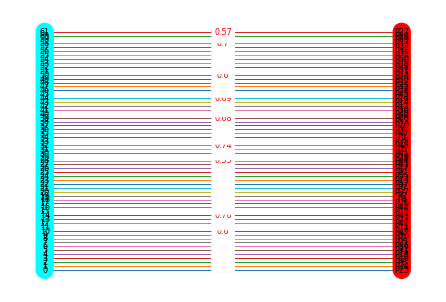

In [11]:
# VISUALIZE MATCHES
import networkx as nx

# Initialise graph
G = nx.Graph()

# origin nodes
partner1 = df['id'].tolist()
partner2 = ["P%s" %int(x) for x in df['partner'].unique().tolist() if not pd.isna(x)]


# Add nodes
G.add_nodes_from(partner1, bipartite = 0)
G.add_nodes_from(partner2, bipartite = 1)

for index, row in df.iterrows():
    node1 = row['id']
    node2 = row['partner']
    weight = row['compatibility_score']
    if not pd.isna(weight):
        G.add_edge(node1, "P%s" %int(node2), weight=weight)
    
# visualize the bipartite graph
edge_colors = {edge: f'C{i}' for i, edge in enumerate(G.edges)}
node_color = ['red' if node in partner2 else 'cyan' for node in G.nodes()]
weights = nx.get_edge_attributes(G, 'weight')
edge_labels = {key:round(weights[key],2) for key in weights}

pos = nx.bipartite_layout(G, partner1, scale = 5)
pos.update({node: [0, i] for i, node in enumerate(partner1)})
pos.update({node: [1, i] for i, node in enumerate(partner2)})
nx.draw(G, pos=pos, with_labels=True, edge_color = edge_colors.values(), node_color = node_color, font_size = 8)
nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_color = 'red', font_size = 8)
nx.draw_networkx_edge_labels(G, pos, edge_labels = {}) # silence the print

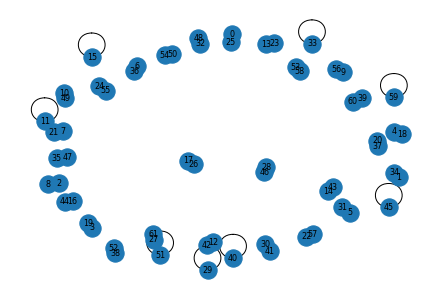

In [12]:
G = nx.from_pandas_edgelist(df, 'id', 'partner')
nx.draw_spring(G, with_labels = True, font_size = 8)

#### **Model Analysis**
From the above visualisation, we can observe that we have successfully paired people together based on compatibility scores. We can also note that each person is only entitled to 1 partner for the matching. There will unfortunately be people who will not be matched due to constraints like gender, age, availability and compatibility.

Let's analyze the model's performance for different problem sizes N

Being solved by Gurobi...
Solution status: 2
Running time: 0.0020s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0040s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0020s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0130s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0050s
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Being solved by Gurobi...
Solution status: 2
Running time: 0.0130s
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Being solved by Gurobi...
Solution status: 2
Running time: 0.0190s


<AxesSubplot: title={'center': 'Average number of matches for different problem sizes'}, xlabel='trial size'>

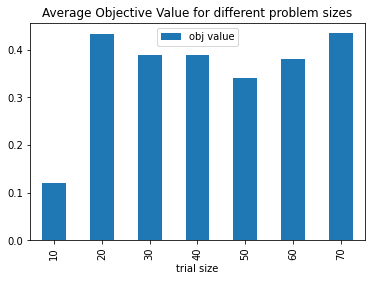

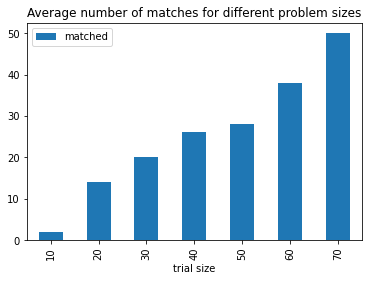

In [44]:
### Purely empirical study

def count_match(X):
    return X.sum() # total number of people who found a pair

sample_sizes = [10, 20, 30, 40, 50, 60, 70]

study_data = list()

threshold = 0.5 # our desired study threshold

for sample_size in sample_sizes:
    sample = populate_data(sample_size)
    
    data = dict()
    
    age = list(sample['age'])
    gap = list(sample['gap'])
    gender = list(sample['gender'])
    preferences = list(sample['preferences'])
    interests = list(sample['interests'])
    seriousness = list(sample['seriousness'])
    similarity_pref = list(sample['similarity_pref'])
    rankings = list(sample['rankings'])
    traits = list(sample['traits'])
    traits_pref = list(sample['traits_pref'])
    budget = list(sample['budget'])
    min_duration = list(sample['min_duration'])
    max_duration = list(sample['max_duration'])
    max_distance = list(sample['max_distance'])
    calendar = list(sample['calendar'])

    obj_value, X = compatibility_matching(sample_size, threshold, age, gender, preferences, gap, interests, similarity_pref, traits, traits_pref, seriousness, rankings, min_duration, calendar)
    
    data["trial size"] = sample_size
    data["obj value"] = obj_value/sample_size
    data["matched"] = count_match(X)
    
    study_data.append(data)

study_df = pd.DataFrame(study_data)

study_df.plot.bar(x="trial size", y="obj value", title = "Average Objective Value for different problem sizes")
study_df.plot.bar(x="trial size", y="matched", title = "Average number of matches for different problem sizes")

**Matching Efficiency**

Most interestingly, we note that the number of matches significantly increase with problem size N. This makes sense because the bigger the pool of participants, the more likely it is for everyone to find a compatible match within that pool.

**Matching Quality**

We can also study how the matching quality changes with increasing problem size N. To do this, We find the *average objective value (total objective value divided by N)* tather than absolute value for each size N since it's natural for objective value of higher sample sizes to be higher (more matches).

Careful observation tells us that the average quality of matches is relatively stable when N is increasing, this could be due to the model's strategic balancing between satisfying everyone's preference and making as many matches as possible.

**Choosing problem size N**

We now know that increase to the pool of participants will be advantageous as the model not only perform more matches, the quality of said matches do not suffer. As such, a real implementation should try to use some large N that is reasonably computable.

**Improving the model**

One should take note that the study performed above is executed on randomly populated data (we undertook such an assumption to simulate worse case and realism) and this leaves a lot of room for improvement.

The model can become more optimized if the group of people to be matched are grouped strategically. For example, this could mean grouping people together with the similar age, interest, schedule, etc.

Using the model on strategically grouped participants will yield better matching results due to some of the constraints being relaxed by the nature of the grouping. In such cases, one would observe better matching quality and volume.

## **PART 2: THE DATE PLANNING MODEL**
Now that we understand how matchmaking works, let's try to plan dates for each of the participants that got paired. There will be no new inputs at this stage of the model as the data originally provided by the user for PART 1 will suffice. The idea is that, as the matchmaker, we are in a very good position to understand both parties in a pairing and this allows us to recommend date activities that best accomodate to both parties' preference.

**For date and time of each date, we will take the timing suggested earlier by the matchmaking model. We assume this to be best dating day and time for both parties**

In [13]:
from rsome import ro
from rsome import grb_solver as grb
import gurobipy as gp
from math import sqrt
import pandas as pd
import numpy as np
# import random
import itertools
import folium
from folium.plugins import BeautifyIcon
import openrouteservice as ors
import requests

## **Data we will use** (from earlier):
Each partner in a pair will already have the following data points:
1. **Interest scores for each activities**
2. **Budget**
3. **Distance**
4. **Maximum Duration of date** (note that minimum date duration already satisfied by matchmaking model from earlier)

To satisfy everyone's preference, we will take the conservative stance (favor the more limiting preference of the two persons):

* For *interest*, we will take the average of the interest array scores. (sum and divide by two)
* For *budget*, we will take the lower of the two budgets
* For *distance*, we will take the lower distance value of the two. *Distance* here refers to the maximum allowed distance between any two dating locations (attractions)
* For *duration* of the date, we will take either the *Longest Common Contiguous Availability* (found in part 1) OR the lower of the two's maximum date duration, whichever is the lowest.

**We will also need a list of attractions to serve as places of interests for dating**

### **Loading the attraction dataset**
We now import the list of dating locations (our database).
Each location has a:
* **name**
* **type** (Adventure, Wellness, etc.) that correspond to the 'interest' array that each participants have
* **monetary cost** attached to visiting & enjoying the location
* **duration** to indicate how long people typically spend there.

*There is Lat and Lng attributes as well for us to visualise the locations on Google Maps later.

NOTE: We have only 50 locations for our demo due to the fact that we require the aid of *openrouteservice API* in our third and final model and Open Route doesn't allow us to include more than 50 data points.

In [14]:
pd.set_option('display.max_rows',None)
data = pd.read_csv("attractions.csv")
data.head()
data.describe()

,No.,Cost,Duration (Hours),Lat,Long,Interest Level
count,50.00000,50.000000,50.000000,50.000000,50.000000,0.0
mean,25.50000,15.932000,1.830000,1.316056,103.838585,NaN
std,14.57738,13.529581,1.214748,0.053330,0.049354,NaN
min,1.00000,0.000000,0.500000,1.250268,103.682524,NaN
25%,13.25000,6.375000,1.000000,1.280112,103.817115,NaN
50%,25.50000,14.000000,1.750000,1.301793,103.835817,NaN
75%,37.75000,23.000000,2.000000,1.344450,103.858476,NaN
max,50.00000,54.500000,8.000000,1.448160,103.975580,NaN


### Processing the data and setting up Open Routes API

In [15]:
## getting availability matrix
n = len(data)

cost_arr = data['Cost'].to_numpy()
time_arr = data['Duration (Hours)'].to_numpy()

#obtaining distance matrix
lon = data['Long']
lat = data['Lat']
lon = [lon[i] for i in range(n)]
lat = [lat[i] for i in range(n)]
latlon = [[lat[i], lon[i]] for i in range(n)]
lonlat = [[lon[i], lat[i]] for i in range(n)]

import requests
body = {"locations":lonlat[0:n],"metrics":["distance"]} ## maximum 50 locations

headers = {
    'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
    'Authorization': '5b3ce3597851110001cf6248461b49469edd44338636a3d8c38144ee', ## Please insert your key here
    'Content-Type': 'application/json; charset=utf-8'
}
call = requests.post('https://api.openrouteservice.org/v2/matrix/driving-car', json=body, headers=headers)
print(call.status_code, call.reason)
data_req = call.json()
d = np.array(data_req['distances'])/1000

200 OK


### User input for testing (Optional)
This section is included to allow the user to test the model's robustness, you can enter the fictional data points for two person's and observe the dating plan that the model comes up with.

**Skip this section, if you want to use the data already provided by PART 1.**

In [80]:
def getUserInput(data):
    a = []
    b = []
    print("-------------Partner 1-------------")
    for category in data.Type.unique():
        interest_level = 0
        while (interest_level > 5) or (interest_level <1):
            interest_level = int(input(f'On a scale of 1(Low) to 5(High), enter your interest level for {category} type of activities:'))
            print('Please enter a number between 1 and 5')
        print(f'Interest level for {category} is {interest_level}')
        a.append(interest_level)
        # data.loc[data.Type == category, 'Interest Level'] = interest_level
    # budget
    budget1 = int(input('Enter your budget:'))
    # distance between locations
    distance1 = int(input('Enter your maximum distance between attractions:'))
    # duration of date (in hours)
    duration1 = int(input('Enter your desired date duration in hours:'))
        
    print("-------------Partner 2-------------")
    for category in data.Type.unique():
        interest_level = 0
        while (interest_level > 5) or (interest_level <1):
            interest_level = int(input(f'On a scale of 1(Low) to 5(High), enter your interest level for {category} type of activities:'))
            print('Please enter a number between 1 and 5')
        print(f'Interest level for {category} is {interest_level}')
        b.append(interest_level)
        # data.loc[data.Type == category, 'Interest Level'] = interest_level
    # budget
    budget2 = int(input('Enter your budget:'))
    # distance between locations
    distance2 = int(input('Enter your maximum distance between attractions:')) 
    # duration of date (in hours)
    duration2 = int(input('Enter your desired date duration in hours:'))
        
    
    a, b = np.array(a), np.array(b) 
    avg_interest = (a + b)/2
    
    i = 0
    for category in data.Type.unique():
        data.loc[data.Type == category, 'Interest Level'] = avg_interest[i]
        i+=1

    # assume lesser of the two
    budget = min(budget1, budget2)
    distance = min(distance1, distance2)
    duration = min(duration1, duration2)
    interest = data['Interest Level'].to_numpy()

    return data, budget, distance, duration, interest

data, budget, distance, duration, interest = getUserInput(data)
I = interest

-------------Partner 1-------------
On a scale of 1(Low) to 5(High), enter your interest level for Adventure type of activities: 4
Please enter a number between 1 and 5
Interest level for Adventure is 4
On a scale of 1(Low) to 5(High), enter your interest level for Animals and Nature type of activities: 2
Please enter a number between 1 and 5
Interest level for Animals and Nature is 2
On a scale of 1(Low) to 5(High), enter your interest level for Art and Culture type of activities: 3
Please enter a number between 1 and 5
Interest level for Art and Culture is 3
On a scale of 1(Low) to 5(High), enter your interest level for Fitness type of activities: 5
Please enter a number between 1 and 5
Interest level for Fitness is 5
On a scale of 1(Low) to 5(High), enter your interest level for Foodie type of activities: 5
Please enter a number between 1 and 5
Interest level for Foodie is 5
On a scale of 1(Low) to 5(High), enter your interest level for Recreational type of activities: 5
Please ente

#### **Select pairs for date planning using PART 1 matches**

*Don't run this part if you are planning to use your own inputs from the earlier section*

We extract the pairs that were matched in part 1 to be used in our model.

In [16]:
df # dataframe from part 1 containing all the data we need.

pairs = df.dropna().reset_index(drop=True) # only non-pairs will have NaN (missing data)

pairs = pairs.loc[:, ["id", "partner", "LCCA", "interests", "min_duration", "max_duration", "budget", "max_distance"]]
pairs # show only relevant fields

,id,partner,LCCA,interests,min_duration,max_duration,budget,max_distance
0,0,25,4.0,"[4, 4, 5, 5, 3, 3, 4, 1]",2,3,20,15
1,1,34,5.0,"[3, 3, 4, 5, 1, 4, 4, 2]",1,3,20,39
2,2,8,3.0,"[4, 3, 1, 1, 1, 2, 3, 1]",1,3,10,48
3,3,19,3.0,"[2, 1, 3, 4, 3, 3, 5, 2]",3,4,40,48
4,4,18,5.0,"[4, 4, 2, 1, 2, 4, 2, 4]",2,7,20,6
5,5,31,4.0,"[3, 4, 4, 2, 2, 4, 3, 4]",2,3,20,41
6,6,36,3.0,"[4, 2, 2, 1, 2, 3, 4, 5]",3,5,30,49
7,7,21,3.0,"[4, 1, 4, 1, 5, 5, 5, 3]",1,3,10,6
8,8,2,3.0,"[2, 4, 4, 5, 1, 1, 2, 5]",2,4,20,18
9,9,56,4.0,"[4, 4, 4, 5, 5, 5, 3, 2]",3,6,40,34


Choose one of the pair above to **plan a date for**!

In [19]:
pair_index = int(input("Select the index of the pair you wish to plan a date for: "))

print("The pair you have selected is:")
person1 = pairs.iloc[pair_index]["id"]
person2 = pairs.iloc[pair_index]["partner"]
pair = pairs.loc[pairs['id'].isin((person1,person2))]
pair

Select the index of the pair you wish to plan a date for:  12


The pair you have selected is:


,id,partner,LCCA,interests,min_duration,max_duration,budget,max_distance
12,13,23,4.0,"[3, 4, 4, 5, 1, 1, 5, 4]",2,7,50,28
21,23,13,4.0,"[3, 2, 3, 5, 2, 2, 2, 5]",2,4,40,31


Based on the pair you have chosen above, let's compute their **budget**, **duration**, **interest** and **distance** constraints. We will take conservative estimates by setting budget and distance to the lower amount of the two. Duration will be either the Longest Common Contiguous Availability (matchmaking model found this), or either of the two's max duration preference, whichever is lowest. For interest, as already mentioned, we will take the average of the two's interest array in order to plan something that interest both parties.

In [20]:
# Insert the couple's interest scores into the dataframe for the model to reference
def get_avg_int_array(data, avg_interest):
    i = 0
    for category in data.Type.unique():
        data.loc[data.Type == category, 'Interest Level'] = avg_interest[i]
        i+=1
    I = data['Interest Level'].to_numpy()
    
    return I

# Take the average interest between the two interest array
def get_avg_int(a, b):
    a, b = np.array(a), np.array(b) 
    return (a + b)/2

avg_interest = get_avg_int(pair["interests"].iloc[0], pair["interests"].iloc[1])
I = get_avg_int_array(data, avg_interest)
print("Averaged Interest Array: %s" %I)

# Take the lower of the two distance
distance = min(pair["max_distance"].iloc[0], pair["max_distance"].iloc[1])
print("maximum distance between two locations: %s" %distance)

# Take the lower of the two budgets
budget = min(pair["budget"].iloc[0], pair["budget"].iloc[1])
print("maximum budget expenditure: %s" %budget)

# Take the lower of LCCA and the two max_durations
duration = min(pair["LCCA"].iloc[0], pair["max_duration"].iloc[0], pair["max_duration"].iloc[1])
print("optimal duration for date: %s" %duration)

Averaged Interest Array: [3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.5 3.5 3.5 3.5
 3.5 3.5 5.  5.  5.  5.  5.  1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5
 1.5 1.5 3.5 3.5 3.5 3.5 3.5 3.5 4.5 4.5 4.5 4.5 4.5 4.5]
maximum distance between two locations: 28
maximum budget expenditure: 40
optimal duration for date: 4.0


## Mathematical Formulation of LOP for the Date planning model

Objective Function: To maximise couple interest levels
$$
\begin{align}
\max \sum_{j = 1}^n x_{j} I_j &&  \\
\end{align}
$$

where 
$$
x_{j} = \begin{cases} 
1 & \text{attraction } j \text{ is selected} \\ 
0 & \text{otherwise} 
\end{cases}
$$

$$
p_{jk} = \begin{cases} 
1 & \text{attractions } j \text{ and } k \text{ are selected} \\ 
0 & \text{otherwise} 
\end{cases}
$$

$$
\begin{align}
I_{j} = \text {interest level of attraction } j\\ 
\end{align}
$$

## Constraints

subject to:

\begin{align}
     & \text {Constraint 1: At least 1 attraction is suggested} \\
     & \sum_{j = 1}^{n} x_{j} \geq 1 && \text{Where } n \text{ is the number of attractions} \\
     & \\
     & \text {Constraint 2: Total cost of all suggested attractions less than budget} \\
     & \sum_{j = 1}^{n} x_{j} c_{j} \leq budget \\
     &\\
     & \text {Constraint 3: Total time of all suggested attractions less than time} \\
     & \sum_{j = 1}^{n} x_{j} t_{j} \leq time \\
     & \\
     & \text{Constraints 4 to 6 ensure that if locations j and k are selected, } \\
     & p_{jk} \text{ cannot be more than 1} \\
     & \\ 
     & \text {Constraint 4 } \\
     & \sum_{j = 1}^{n} \sum_{k = 1}^{n} p_{jk} \geq x_j + x_k - 1 \\
     &\\
     & \text{Constraint 5 } \\
     & \sum_{j = 1}^{n} \sum_{k = 1}^{n} p_{jk} \leq x_j \\
     &\\
     & \text{Constraint 6 } \\
     & \sum_{j = 1}^{n} \sum_{k = 1}^{n} p_{jk} \leq x_k \\
     &\\
     & \text{Constraint 7: If locations j and k are selected, the } \\
     & \text{distance between them is less than } distance \\
     &\\ 
     & \sum_{j = 1}^{n} \sum_{k = 1}^{n} p_{j,k} * D_{j,k} \leq distance && \text{Where } D \text{ is the distance between j and k} \\
     &\\
\\
\end{align}

In [21]:
def dateplanning(I, budget, duration, distance):
    #### NEW CODE
    model = ro.Model("Date Planning")
    x = model.dvar(n, vtype="B")
    p = model.dvar((n, n), vtype="B")

    # objective function
    model.max(sum(x[j]*I[j] for j in range(n)))

    # distance between attractions constraint
    combinations = list(itertools.combinations([i for i in range(n)], 2))
    for j, k in combinations:
        model.st(p[j][k] >= x[j] + x[k] - 1)
        model.st(p[j][k] <= x[j])
        model.st(p[j][k] <= x[k])
        model.st(p[j][k] * d[j][k] <= distance)

    # at least 1 attraction for the date
    model.st(x.sum() >= 1)

    # total cost is less than or equal to budget
    model.st(sum(x[j]*cost_arr[j] for j in range(n)) <= budget)

    # duration is less than or equal to time available
    model.st(sum(x[j]*time_arr[j] for j in range(n)) <= duration)

    model.solve(grb)

    return model.get(), x.get()

obj_value, x = dateplanning(I, budget, duration, distance)

Being solved by Gurobi...
Solution status: 2
Running time: 0.0360s


### **The Results**

Based on the couple you have chosen to plan a date for, the following is the best dating locations/activities for them based on their budget, distance, interest & duration constraints.

In [22]:
chosen_index = []
activities = x
for i, b in enumerate(activities):
    if b:
        chosen_index.append(i)

chosen_activities = data.loc[chosen_index].reset_index().drop(columns = 'index')
total_cost = chosen_activities['Cost'].sum()

In [23]:
print('Your ideal date would include these locations:')
for each in list(chosen_activities.Location):
    print(each)

print(f'The total cost of your date would be: ${total_cost:.2f}')

Your ideal date would include these locations:
Gallop Stable (Horse Riding)
Gardens by the Bay (OCBC Skyway)
SkyHelix Sentosa
Singapore Cable Car
Gardens by the Bay (Supertree Grove)
The total cost of your date would be: $32.10


In [24]:
chosen_activities

,No.,Location,Type,Cost,Duration (Hours),Lat,Long,Interest Level
0,14,Gallop Stable (Horse Riding),Animals and Nature,5.0,0.5,1.333475,103.797447,3.0
1,39,Gardens by the Bay (OCBC Skyway),Sightseeing,5.0,1.0,1.283199,103.866697,3.5
2,40,SkyHelix Sentosa,Sightseeing,8.1,1.0,1.255099,103.818120,3.5
3,42,Singapore Cable Car,Sightseeing,14.0,0.5,1.271359,103.819782,3.5
4,43,Gardens by the Bay (Supertree Grove),Sightseeing,0.0,1.0,1.282155,103.864324,3.5


## **PART 3: ROUTE PLANNING**
Having determined the dating locations, the next step is for completeness: find the optimal path to travel to all the attractions. This is done to the convenience of the user, in reality, they can augment their paths and visit only the locations they so wish.

In [25]:
## Plot chosen locations
lon = chosen_activities['Long']
lat = chosen_activities['Lat']
N = len(chosen_activities) 
lon = [lon[i] for i in range(N)]
lat = [lat[i] for i in range(N)]
latlon = [[lat[i], lon[i]] for i in range(N)]
lonlat = [[lon[i], lat[i]] for i in range(N)]

SGmap = folium.Map(location=[lat[0], lon[0]], tiles="Stamen Terrain", zoom_start=11.5) #Stamen Terrain, OpenStreetMap
for i in range(N):
    folium.Marker(
        location=[lat[i], lon[i]],
        icon=BeautifyIcon(
            icon_shape='marker',
            number=int(i),
            spin=True,
            text_color='red',
            background_color="#FFF",
            inner_icon_style="font-size:12px;padding-top:-5px;"
        )
    ).add_to(SGmap)
SGmap

We allow the user to decide the starting location and we will solve the shortest path using said starting location. Otherwise, we will create a general loop that assumes that the user intents to start and stop at the same location (allowing them to start at any point).

In [26]:
if len(chosen_activities) >=2:
    ## choosing of starting location
    choice = input('Do you want to choose which attraction to visit first? (Y/N)')
    if choice == 'Y':
        starting_location = int(input('Where do you want to start off first? (Select by index):'))
        print(f'You have chosen to start at {chosen_activities.iloc[starting_location,1]}')
        # Move target row to first element of list.
        idx = [starting_location] + [i for i in range(len(chosen_activities)) if i != starting_location]
        chosen_activities = chosen_activities.iloc[idx].reset_index().drop(columns = 'index')

        ## obtain the new lat lon array. If starting location changed
        chosen_activities
        lon = chosen_activities['Long']
        lat = chosen_activities['Lat']
        N = len(chosen_activities) 
        lon = [lon[i] for i in range(N)]
        lat = [lat[i] for i in range(N)]
        latlon = [[lat[i], lon[i]] for i in range(N)]
        lonlat = [[lon[i], lat[i]] for i in range(N)]

    else:
        print('Ok')

Do you want to choose which attraction to visit first? (Y/N) N


Ok


# TSP Formula **(Miller–Tucker–Zemlin formulation)**
We use the MTZ formulation to solve the Traveling Sales Person problem.

Label the attractions with the numbers $1,\ldots,N$ where N is total number of chosen attractions

Objective Function: To minimize the total distance travelled
$$
\begin{align}
\min &\sum_{i=1}^N \sum_{j=1}^N d_{ij}x_{ij}\colon &&  \\
\end{align}
$$

where 
$$
x_{ij} = \begin{cases} 
1 & \text{the path goes from attraction } i \text{ to attraction } j \\ 
0 & \text{otherwise} 
\end{cases}
$$

$$
\begin{align}
d_{ij} = \text {the distance between attraction i and attraction j} \\ 
\end{align}
$$

subject to:
\begin{align}
     & \text {Constraint 1: Only 1 path goes to attraction j} \\
     & \sum_{i=1}^N x_{ij} = 1 && j=1, \ldots, N; \\ 
     & \\
     & \text {Constraint 2: Only 1 path comes from attraction i} \\
     & \sum_{j=1}^N x_{ij} = 1 && i=1, \ldots, N; \\
     & \\
     & \text {Constraint 3: If there is a path from i to j, Ui comes after Uj}\\
     & u_i-u_j +Nx_{ij} \le N-1 && 2 \le i \ne j \le N;  \\
     & 1 \le u_i \le N-1 && 2 \le i \le N; \\
     & u_{i} \in \mathbf{Z} && i=2, \ldots, N; \\
     & \text {Where } u_{i} \text { is a dummy variable indicating the order which the attraction is visited}  && i=2, \ldots, N;\\
     &\\
     & \text {Constraint 4: Xij is binary} \\
     & x_{ij} \in \{0,1\}  && i,j=1, \ldots, N; \\
     &\\
     & \text {Constraint 5: You cannot travel to the same attraction from the same attraction} \\
     & x_{ii} = 0  && i= 1, \ldots, N; \\
\end{align}


In [27]:
def TSP_MTZ(N,distance):
    ## Miller–Tucker–Zemlin formulation
    m = ro.Model('TSP-MTZ')
        
    x = m.dvar((N,N),'B')
    u = m.dvar(N, 'I')
    m.min( (distance * x).sum() ) 

    m.st( x[i,i] == 0 for i in range(N) )

    m.st( x.sum(axis = 0) == 1, 
         x.sum(axis = 1) == 1 )

    for i in range(1,N):
        m.st( u[i] <= N - 1, u[i] >= 1 )
        for j in range(1,N):
            m.st( u[i] - u[j] + N*x[i,j] <= N - 1 )

    m.solve(grb)
    x_star = x.get()
    obj = m.get()
    u_star = u.get()
    return x_star, obj, u_star

In [28]:
## obtain route sequence
def obtain_route(x_star, lon, lat, K = 1):
    N = len(lon)
    seq_route = -np.ones((K,N + 1)) # route sequence
    lon_route = -np.ones((K,N + 1))
    lat_route = -np.ones((K,N + 1))

    # starting point
    lon_route[:,0] = lon[0]
    lat_route[:,0] = lat[0]
    seq_route[:,0]= 1

    ind = np.argwhere( x_star )

    for k in range(K):
        lon_route[k,1] = lon[ind[k,1]]
        lat_route[k,1] = lat[ind[k,1]]
        seq_route[k,1]= ind[k,1] + 1


        ind_j = ind[k][1]
        i = 1
        while ind_j != 0:
            i = i + 1
            seq_route[k,i] = ind[ind_j + K - 1,1] + 1
            lon_route[k,i] = lon[ind[ind_j + K - 1,1]]
            lat_route[k,i] = lat[ind[ind_j + K - 1,1]]

            ind_j = ind[ind_j + K - 1,1]
        
    return seq_route, lon_route, lat_route

In [29]:
## obtain the distance matrix for chosen attractions
if len(chosen_activities) >=2:
    body = {"locations":lonlat[0:N],"metrics":["distance"]}

    headers = {
        'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
        'Authorization': '5b3ce3597851110001cf62489623019926ee439b8291a3fdc567d44e', ## Please insert your key here
        'Content-Type': 'application/json; charset=utf-8'
    }
    call = requests.post('https://api.openrouteservice.org/v2/matrix/driving-car', json=body, headers=headers)
    print(call.status_code, call.reason)
    data_req = call.json()
    distance_mat = np.array(data_req['distances'])/1000

200 OK


#### **We run this model only if number of chosen attractions >= 3**

In the cell below, we would be plotting the shortest path between the attractions. If the number of chosen attractions >=3, we will run the TSP model to obtain the shortest path. However, if there are only 2 locations, we do not run the TSP model as there is no point in running the model. The shortest path is just a route between the 2 locations. Similarly, we also do not run the model if there is only 1 chosen location

In [30]:
### Plot locations
SGmap = folium.Map(location=[lat[0], lon[0]], tiles="Stamen Terrain", zoom_start=11.5) #Stamen Terrain, OpenStreetMap
for i in range(N):
    folium.Marker(
        location=[lat[i], lon[i]],
        icon=BeautifyIcon(
            icon_shape='marker',
            number=int(i),
            spin=True,
            text_color='red',
            background_color="#FFF",
            inner_icon_style="font-size:12px;padding-top:-5px;"
        )
    ).add_to(SGmap)

if len(chosen_activities) >=3:
    ### run TSP model using route distances
    x_MTZ, obj_MTZ, u_MTZ = TSP_MTZ(N, distance_mat)
    ### Get route sequence
    seq_route_tsp, lon_route_tsp, lat_route_tsp = obtain_route(x_MTZ, lon[0:N], lat[0:N])

    ### Plot Route
    lon_route = lon_route_tsp[0]
    lat_route = lat_route_tsp[0]
    for i in range(N):
        # Specify your personal API key, registered in openrouteservice.org
        client = ors.Client(key = '5b3ce3597851110001cf62489623019926ee439b8291a3fdc567d44e') ## Please insert your token here
        coordinates = [[lon_route[i], lat_route[i]], [lon_route[i + 1], lat_route[i + 1]]]

        route = client.directions(coordinates = coordinates, profile = 'driving-car', format = 'geojson') #driving-car, cycling-road, cycling-regular, foot-walking

        gj = folium.GeoJson(
            name='route',
            data={"type": "FeatureCollection", "features": [{"type": "Feature",
                                                             "geometry": route['features'][0]['geometry']}]},
        )
        gj.add_to(SGmap)

    folium.LayerControl().add_to(SGmap)
    display(SGmap)
    
    paths = []
    for i in range(N):
        for each in range(N):
            if x_MTZ[i][each] == 1:
                paths.append((i,each))

    print(f'Ideal path is {paths}')

elif len(chosen_activities) == 2:
    
    lon.append(lon[0])
    lat.append(lat[0])
    for i in range(N):
        # Specify your personal API key, registered in openrouteservice.org
        client = ors.Client(key = '5b3ce3597851110001cf62489623019926ee439b8291a3fdc567d44e') ## Please insert your token here
        coordinates = [[lon[i], lat[i]], [lon[i + 1], lat[i + 1]]]

        route = client.directions(coordinates = coordinates, profile = 'driving-car', format = 'geojson') #driving-car, cycling-road, cycling-regular, foot-walking

        gj = folium.GeoJson(
            name='route',
            data={"type": "FeatureCollection", "features": [{"type": "Feature",
                                                             "geometry": route['features'][0]['geometry']}]},
        )
        gj.add_to(SGmap)

    folium.LayerControl().add_to(SGmap)
    display(SGmap)

elif len(chosen_activities) == 1:
    display(SGmap)

Being solved by Gurobi...
Solution status: 2
Running time: 0.0130s


Ideal path is [(0, 4), (1, 3), (2, 0), (3, 2), (4, 1)]
